# Bootstrap SNN Training

The underlying principle for ANN-SNN conversion is that the ReLU activation function (or similar form) approximates the firing rate of an LIF spiking neuron. Consequently, an ANN trained with ReLU activation can be mapped to an equivalent SNN with proper scaling of weights and thresholds. However, as the number of time-steps reduces, the alignment between ReLU activation and LIF spiking rate falls apart mainly due to the following two reasons (especially, for discrete-in-time models like Loihi’s CUBA LIF):

* With less time steps, the SNN can assume only a few discrete firing rates.
* Limited time steps mean that the spiking neuron activity rate often saturates to maximum allowable firing rate.

Introducing __Bootstrap training__. An SNN is used to jumpstart an equivalent ANN model which is then used to accelerate SNN training. There is no restriction on the type of spiking neuron or it's reset behavior. It consists of following steps:
![](fit.png)

* Input output data points are first collected from the network running as an SNN: __SAMPLING mode__. 
* The data is used to estimate the corresponding ANN activation as a piecewise linear layer, unique to each layer: __FIT mode__.
* The training is accelerated using the piecewise linear ANN activation: __ANN mode__.
* The network is seamlessly translated to an SNN: __SNN mode__.
* _SAMPLING mode_ and _FIT mode_ are repeated for a few iterations every couple of epochs, thus maintaining an accurate ANN estimate.


<table><tr>
<td> <img src="bootstrap.png" alt="Drawing" style="height: 400px;"/> </td>
</tr>
</table>

Bootstrap training is available as __`lava.lib.dl.bootstrap`__. The main modules are 

* `block`: provides `lava.lib.dl.slayer.block` based network definition interface.
* `ann_sampler`: provides utilities for sampling SNN data points and pievewise linear ANN fit.
* `routine`: `routine.Scheduler` provides scheduling utility to seamlessly switch between SAMPLING | FIT | ANN | SNN mode.
    * It also provides ANN-SNN bootstrap hybrid traiing utility as well (Not demonstrated in this tutorial).
    
<table><tr>
<td> <img src="scheduler.png" alt="Drawing" style="height: 350px;"/> </td>
</tr>
</table>

## MNIST Classification

Here, we will demonstrate botstrap SNN training on the well known MNIST classification problem.


In [1]:
import os, sys
import h5py
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

# import slayer from lava-dl
import lava.lib.dl.slayer as slayer
import lava.lib.dl.bootstrap as bootstrap

import IPython.display as display
from matplotlib import animation

# Create Network

The network definition follows standard PyTorch way using `torch.nn.Module`.

`lava.lib.dl.bootstrap` provides __block interface__ similar to `lava.lib.dl.slayer.block` - which bundles all these individual components into a single unit. These blocks can be cascaded to build a network easily. The block interface provides additional utilities for normalization (weight and neuron), dropout, gradient monitoring and network export.

In [2]:
class Network(torch.nn.Module):
    def __init__(self, time_steps=16):
        super(Network, self).__init__()
        self.time_steps = time_steps

        neuron_params = {
                'threshold'     : 1.25,
                'current_decay' : 1, # this must be 1 to use batchnorm
                'voltage_decay' : 0.03,
                'tau_grad'      : 1,
                'scale_grad'    : 1,
            }
        neuron_params_norm = {
                **neuron_params, 
                # 'norm'    : slayer.neuron.norm.MeanOnlyBatchNorm,
            }
        
        self.blocks = torch.nn.ModuleList([
                bootstrap.block.cuba.Input(neuron_params, weight=1, bias=0), # enable affine transform at input
                bootstrap.block.cuba.Dense(neuron_params_norm, 28*28, 512, weight_norm=True, weight_scale=2),
                bootstrap.block.cuba.Dense(neuron_params_norm, 512, 512, weight_norm=True, weight_scale=2),
                bootstrap.block.cuba.Affine(neuron_params, 512, 10, weight_norm=True, weight_scale=2),
            ])

    def forward(self, x, mode):
        N, C, H, W = x.shape
        if mode.base_mode == bootstrap.Mode.ANN:
            x = x.reshape([N, C, H, W, 1])
        else:
            x = slayer.utils.time.replicate(x, self.time_steps)

        x = x.reshape(N, -1, x.shape[-1])

        for block, m in zip(self.blocks, mode):
            x = block(x, mode=m)

        return x

    def export_hdf5(self, filename):
        # network export to hdf5 format
        h = h5py.File(filename, 'w')
        simulation = h.create_group('simulation')
        simulation['Ts'] = 1
        simulation['tSample'] = self.time_steps        
        layer = h.create_group('layer')
        for i, b in enumerate(self.blocks):
            b.export_hdf5(layer.create_group(f'{i}'))

# Instantiate Network, Optimizer, DataSet and DataLoader

Here we will use standard _torchvision datasets_ to load MNIST data.

In [3]:
trained_folder = 'Trained'
os.makedirs(trained_folder, exist_ok=True)

# device = torch.device('cpu')
device = torch.device('cuda') 

net = Network().to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

# Dataset and dataLoader instances.
training_set = datasets.MNIST(
        root='data/',
        train=True,
        transform=transforms.Compose([
            transforms.RandomAffine(
                degrees=10, 
                translate=(0.05, 0.05),
                scale=(0.95, 1.05),
                shear=5,
            ),
            transforms.ToTensor(),
            transforms.Normalize((0.5), (0.5)),
        ]),
        download=True,
    )

testing_set = datasets.MNIST(
        root='data/',
        train=False,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5), (0.5)),
        ]),
    )

train_loader = DataLoader(dataset=training_set, batch_size=32, shuffle=True)
test_loader  = DataLoader(dataset=testing_set , batch_size=32, shuffle=True)

stats = slayer.utils.LearningStats()
scheduler = bootstrap.routine.Scheduler()

# Training Loop

Training loop follows standard PyTorch training structure. `bootstrap.routine.Scheduler` helps simplify the complex routine of periodically switching between different bootstrap modes during training. `scheduler.mode(epoch, i, net.training)` provides an iterator which orchestrates the mode of different blocks/layers.

In [4]:
epochs = 100
for epoch in range(epochs):
    for i, (input, label) in enumerate(train_loader, 0):
        net.train()
        mode = scheduler.mode(epoch, i, net.training)

        input = input.to(device)
        output = net.forward(input, mode)
        rate = torch.mean(output, dim=-1).reshape((input.shape[0], -1))

        loss = F.cross_entropy(rate, label.to(device))
        prediction = rate.data.max(1, keepdim=True)[1].cpu().flatten()

        stats.training.num_samples += len(label)
        stats.training.loss_sum += loss.cpu().data.item() * input.shape[0]
        stats.training.correct_samples += torch.sum( prediction == label ).data.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'\r[Epoch {epoch:2d}/{epochs}] {stats}', end='')

    for i, (input, label) in enumerate(test_loader, 0):
        net.eval()
        mode = scheduler.mode(epoch, i, net.training)

        with torch.no_grad():
            input = input.to(device)
            output = net.forward(input, mode=scheduler.mode(epoch, i, net.training))
            rate = torch.mean(output, dim=-1).reshape((input.shape[0], -1))

            loss = F.cross_entropy(rate, label.to(device))
            prediction = rate.data.max(1, keepdim=True)[1].cpu().flatten()

        stats.testing.num_samples += len(label)
        stats.testing.loss_sum += loss.cpu().data.item() * input.shape[0]
        stats.testing.correct_samples += torch.sum( prediction == label ).data.item()

    print(f'\r[Epoch {epoch:2d}/{epochs}] {stats}', end='')

    if mode.base_mode == bootstrap.routine.Mode.SNN:
        scheduler.sync_snn_stat(stats.testing)
        print('\r', ' '*len(f'\r[Epoch {epoch:2d}/{epochs}] {stats}'))
        print(mode)
        print(f'[Epoch {epoch:2d}/{epochs}]\nSNN Testing: {scheduler.snn_stat}')

        if scheduler.snn_stat.best_accuracy:
            torch.save(net.state_dict(), trained_folder + '/network.pt')
        scheduler.update_snn_stat()
            
    stats.update()
    stats.save(trained_folder + '/')

                                                                                                                                                        
Mode: SNN
[Epoch  0/100]
SNN Testing: loss =     0.18656                        accuracy = 0.96080
                                                                                                                                                                                        
Mode: SNN
[Epoch 10/100]
SNN Testing: loss =     0.06348 (min =     0.18656)    accuracy = 0.98460 (max = 0.96080)
                                                                                                                                                                                        
Mode: SNN
[Epoch 20/100]
SNN Testing: loss =     0.04227 (min =     0.06348)    accuracy = 0.98950 (max = 0.98460)
                                                                                                                                                    

# Plot the learning curves

Plotting the learning curves is as easy as calling `stats.plot()`.

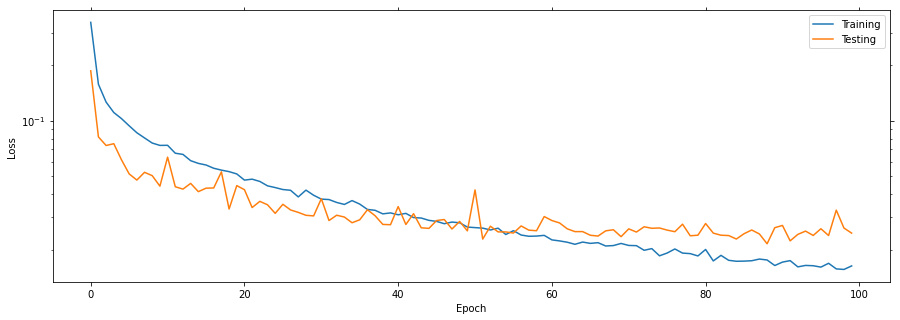

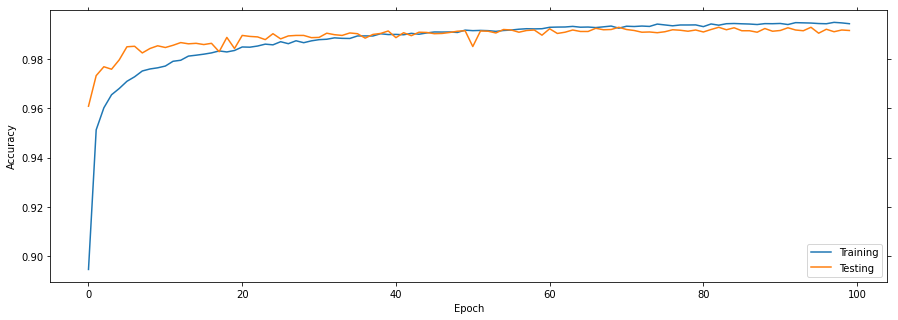

In [5]:
stats.plot(figsize=(15, 5))

# Export the best model

Load the best model during training and export it as hdf5 network. It is supported by `lava.lib.dl.netx` to automatically load the network as a lava process.

In [6]:
net.load_state_dict(torch.load(trained_folder + '/network.pt'))
net.export_hdf5(trained_folder + '/network.net')

# Visualize the network output

Here, we will use `slayer.io.tensor_to_event` method to convert the torch output spike tensor into graded (non-binary) `slayer.io.Event` object and visualize a few input and output event pairs.

In [7]:
output = net(input.to(device), mode=scheduler.mode(100, 0, False))
for i in range(5):
    img = (2*input[i].reshape(28, 28).cpu().data.numpy()-1) * 255
    Image.fromarray(img).convert('RGB').save(f'gifs/inp{i}.png')
    out_event = slayer.io.tensor_to_event(output[i].cpu().data.numpy().reshape(1, 10, -1))
    out_anim = out_event.anim(plt.figure(figsize=(10, 3.5)), frame_rate=2400)
    out_anim.save(f'gifs/out{i}.gif', animation.PillowWriter(fps=24), dpi=300)


In [8]:
img_td = lambda gif: f'<td> <img src="{gif}" alt="Drawing" style="height: 150px;"/> </td>'
html = '<table>'
html += '<tr><td align="center"><b>Input</b></td><td><b>Output</b></td></tr>'
for i in range(5):
    html += '<tr>'
    html += img_td(f'gifs/inp{i}.png')
    html += img_td(f'gifs/out{i}.gif')
    html += '</tr>'
html += '</tr></table>'
display.HTML(html)

Input,Output
,
,
,
,
,
